In [1]:
import os
import pandas as pd
import pickle
import biotype.similarity as sim

In [2]:
DATA_DIR_PATH = "datasets/export"
META_DIR_PATH = "doc"
PEAK_DIR_PATH = "extracted_peaks"
files =  os.listdir(DATA_DIR_PATH)
files = [fn  for fn in files if fn.endswith(".txt")]
files = sorted(files)
for file in files[:5] :
    print(file)

L100_0_G7_1.txt
L100_0_G8_1.txt
L101_0_A1_1.txt
L101_0_A2_1.txt
L102_0_A3_1.txt


In [3]:
meta = pd.read_csv(META_DIR_PATH + '/meta.csv', index_col=0,encoding='utf-8')
meta[['菌株名','血清型']].head()

,菌株名,血清型
MALDITOFMS Listeria serial No.,,
L1,LM1,1/2a
L2,LM3,1/2a
L3,LM4,4b
L4,LM7,1/2a
L5,LM8,1/2a


In [4]:
serotype = meta['血清型'].to_dict()

In [5]:
peaks_extracted = []
n = len(files)
for i in range(n):
    df = None
    df = pd.read_table(f"{DATA_DIR_PATH}/{files[i]}",sep=" ", header=None,names=['m/z', 'intensity']) 
    x, y = df['m/z'].to_numpy(), df['intensity'].to_numpy()

    pickle_file = files[i][:-4] # trim '.txt'
    with open(f'{PEAK_DIR_PATH}/{pickle_file}_peaks.pkl', 'rb') as peak_file:
        peaks = pickle.load(peak_file)
        strain = files[i].split('_')[0]
        stype = serotype.get(strain, 'NA')
        print(f'{pickle_file} ({stype}) peaks: {len(peaks)}')
        peaks_extracted +=  [(x[peaks], y[peaks]) ] 

L100_0_G7_1 (1/2b) peaks: 208
L100_0_G8_1 (1/2b) peaks: 226
L101_0_A1_1 (1/2a) peaks: 226
L101_0_A2_1 (1/2a) peaks: 195
L102_0_A3_1 (1/2b) peaks: 208
L102_0_A4_1 (1/2b) peaks: 200
L103_0_A5_1 (1/2b) peaks: 192
L103_0_A6_1 (1/2b) peaks: 188
L104_0_A7_1 (1/2a) peaks: 193
L104_0_A8_1 (1/2a) peaks: 221
L105_0_A10_1 (1/2b) peaks: 186
L105_0_A9_1 (1/2b) peaks: 204
L106_0_A11_1 (1/2a) peaks: 208
L106_0_A12_1 (1/2a) peaks: 196
L107_0_B1_1 (1/2b) peaks: 190
L107_0_B2_1 (1/2b) peaks: 195
L108_0_B3_1 (UT) peaks: 213
L108_0_B4_1 (UT) peaks: 186
L109_0_B5_1 (UT) peaks: 214
L109_0_B6_1 (UT) peaks: 205
L10_0_G10_1 (1/2a) peaks: 189
L10_0_G9_1 (1/2a) peaks: 197
L110_0_B7_1 (UT) peaks: 190
L110_0_B8_1 (UT) peaks: 203
L111_0_B10_1 (UT) peaks: 240
L111_0_B9_1 (UT) peaks: 214
L112_0_B11_1 (1/2a) peaks: 226
L112_0_B12_1 (1/2a) peaks: 223
L113_0_C1_1 (UT) peaks: 202
L113_0_C2_1 (UT) peaks: 210
L114_0_C3_1 (UT) peaks: 289
L114_0_C4_1 (UT) peaks: 265
L115_0_C5_1 (3a) peaks: 207
L115_0_C6_1 (3a) peaks: 195
L11

In [6]:
def biotype(peaks, algo="jaccard", topn=1, target='strain'):
    """ compute pair-wise similarity by algorithm `algo` and report the `topn` hit ratio 
        by "hit" it means peak lists of the same strain id are smilar enough within topn 
        target: 
        　'strain'（菌株識別）類似する菌株が、菌株IDが同じかどうかを判定する
        　'serotype'（菌種同定）類似する菌株が、菌種(血清型)が同じかどうかを判定する
"""
    rs = []
    for i in range(n-1):
        for j in range(i+1,n):
            score = sim.similar_to(peaks[i], peaks[j], method=algo, rank=2)
            rs += [(i, j, score)]

    rs += [(_j,_i,_s) for _i,_j,_s in rs ]
    hits = 0
    for i in range(n):
        rs_ = [(_i,_j,_s) for _i,_j,_s in rs if _i==i]
        rs_ = sorted(rs_, key=lambda x: x[2], reverse=True)
        hit = 0
        for top in range(topn):
            if top >= len(rs_):
                break
                
            _i, _j , _s = rs_[top]            
            strain1, strain2 = files[_i].split('_')[0], files[_j].split('_')[0] 
            stype1, stype2 = serotype.get(strain1, 'NA'), serotype.get(strain2, 'NA')
            if target=='strain': 
                if strain1==strain2:
                    hit = hit + 1
            elif stype1==stype2 and stype1 != 'NA':
                # print(f"{files[_i][:-4]}:{stype1} + {files[_j][:-4]}:{stype2}")
                hit = hit + 1
        if hit > 0:
            hits = hits + 1
            
        # print("*" * 30)        
        
    return hits

In [7]:
topn = 2
hits = biotype(peaks_extracted, 'jaccard', topn, target='stype')
print(f"hit={hits}, ratio={hits/n/topn}")

hit=77, ratio=0.37745098039215685


In [8]:
algos = {'jaccard':'Jaccard Similarity', 'rank':'Rank Similarity', 'weighted': 'Weighted Rank Similarity'}
stat = {'strain':[], 'serotype':[]}

for target in ['strain', 'serotype']:
    print(f"target={target}, n={n}")
    
    for algo in algos:
        for topn in range(1, 6):
            hit = biotype(peaks_extracted, algo, topn, target)
            stat[target].append( [topn, algo, hit] )
            print(f" - [{algo}] topn={topn}, hit={hit}, hit rate:{hit/n: .3f}")

    print("*" * 50)

target=strain, n=102
 - [jaccard] topn=1, hit=24, hit rate: 0.235
 - [jaccard] topn=2, hit=39, hit rate: 0.382
 - [jaccard] topn=3, hit=49, hit rate: 0.480
 - [jaccard] topn=4, hit=57, hit rate: 0.559
 - [jaccard] topn=5, hit=62, hit rate: 0.608
 - [rank] topn=1, hit=29, hit rate: 0.284
 - [rank] topn=2, hit=36, hit rate: 0.353
 - [rank] topn=3, hit=44, hit rate: 0.431
 - [rank] topn=4, hit=49, hit rate: 0.480
 - [rank] topn=5, hit=53, hit rate: 0.520
 - [weighted] topn=1, hit=31, hit rate: 0.304
 - [weighted] topn=2, hit=42, hit rate: 0.412
 - [weighted] topn=3, hit=46, hit rate: 0.451
 - [weighted] topn=4, hit=51, hit rate: 0.500
 - [weighted] topn=5, hit=58, hit rate: 0.569
**************************************************
target=serotype, n=102
 - [jaccard] topn=1, hit=60, hit rate: 0.588
 - [jaccard] topn=2, hit=77, hit rate: 0.755
 - [jaccard] topn=3, hit=86, hit rate: 0.843
 - [jaccard] topn=4, hit=91, hit rate: 0.892
 - [jaccard] topn=5, hit=91, hit rate: 0.892
 - [rank] topn=

In [9]:
print(stat)

{'strain': [[1, 'jaccard', 24], [2, 'jaccard', 39], [3, 'jaccard', 49], [4, 'jaccard', 57], [5, 'jaccard', 62], [1, 'rank', 29], [2, 'rank', 36], [3, 'rank', 44], [4, 'rank', 49], [5, 'rank', 53], [1, 'weighted', 31], [2, 'weighted', 42], [3, 'weighted', 46], [4, 'weighted', 51], [5, 'weighted', 58]], 'serotype': [[1, 'jaccard', 60], [2, 'jaccard', 77], [3, 'jaccard', 86], [4, 'jaccard', 91], [5, 'jaccard', 91], [1, 'rank', 65], [2, 'rank', 75], [3, 'rank', 81], [4, 'rank', 83], [5, 'rank', 87], [1, 'weighted', 64], [2, 'weighted', 74], [3, 'weighted', 79], [4, 'weighted', 80], [5, 'weighted', 84]]}


  TopN   Jaccard      Rank  Weighted
0    1  0.235294  0.284314  0.303922
1    2  0.382353  0.352941  0.411765
2    3  0.480392  0.431373   0.45098
3    4  0.558824  0.480392       0.5
4    5  0.607843  0.519608  0.568627
  TopN   Jaccard      Rank  Weighted
0    1  0.588235  0.637255  0.627451
1    2  0.754902  0.735294   0.72549
2    3  0.843137  0.794118   0.77451
3    4  0.892157  0.813725  0.784314
4    5  0.892157  0.852941  0.823529


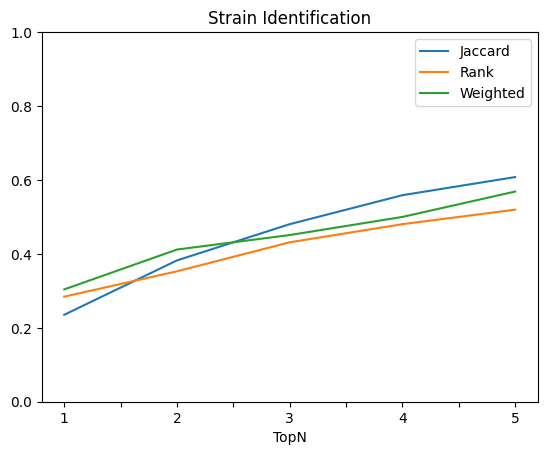

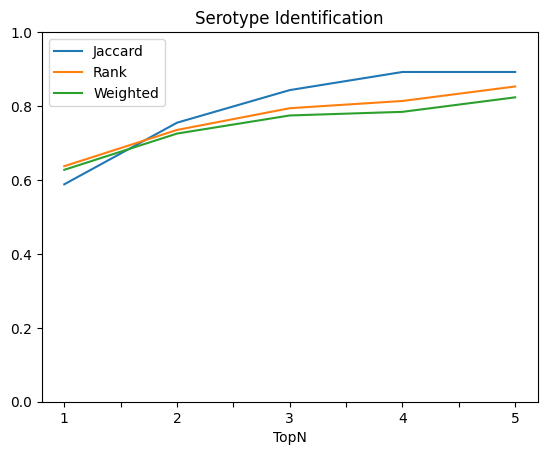

In [10]:
import numpy as np

for target in  ['strain', 'serotype']:
    
    ja = [x[2] for x in stat[target] if x[1]=='jaccard']
    rk = [x[2] for x in stat[target] if x[1]=='rank']
    wt = [x[2] for x in stat[target] if x[1]=='weighted']
    my_stat = []
    for topn in range(1, 6):
        my_stat.append([topn, ja[topn-1]/n, rk[topn-1]/n, wt[topn-1]/n])
    my_array = np.array(my_stat, dtype=object)
    # print(my_array)
    df = pd.DataFrame(my_array, columns = ['TopN','Jaccard','Rank', 'Weighted'])
    print(df)
    title = f"{target} identification".title()
    df.plot(x='TopN',y=['Jaccard','Rank', 'Weighted'],ylim=[0,1.0], title=title)